##### <img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Data preprocessing</center>

# Challenge S5: Liga de Fútbol Profesional

## Objetivos

El objetivo de este challenge es simular mediante el método de montecarlo el resultado de la liga.

Para ello, utilizando las distribuciones de probabilidad, y todos los conceptos previos que hemos aprendido realizaremos una simulación lo más realista posible.

## Configuración del entorno

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

## Carga de datos

Para este challenge dispones de varias fuentes de datos que puedes utilizar:

* `equipos_liga_2019-20.txt` Fichero TXT con los equipos que han disputado la temporada 2019 - 2020 en la primera división de Liga de Fútbol profesional en España.
* `clasificacion_historica.csv` Fichero con resultados acumulados de todos los equipos que han jugado alguna vez en primera division.
* Cualquier otra fuente de datos que quieras añadir o información tuya si sabes mucho de fútbol 😄.

El primer paso será la carga de datos a partir del fichero `TXT`. Como sólo contiene el nombre de los equipos meteremos los valores en una lista.

In [2]:
with open('equipos_liga_2019-20.txt', encoding='utf-8') as f:
    equipos = f.readlines()
    equipos = [x.strip() for x in equipos] 

equipos

['D. Alavés',
 'Athletic Club',
 'Atlético de Madrid',
 'FC Barcelona',
 'Real Betis',
 'RC Celta',
 'SD Eibar',
 'RCD Espanyol',
 'Getafe CF',
 'Granada CF',
 'CD Leganés',
 'Levante UD',
 'RCD Mallorca',
 'C.A. Osasuna',
 'Real Madrid',
 'Real Sociedad',
 'R. Valladolid CF',
 'Sevilla FC',
 'Valencia CF',
 'Villarreal CF']

## Simulador de partidos

El primer paso para realizar un análisis de montecarlo es definir la función que nos permita simular cada caso individual, en nuestro casos son los partidos. Puedes implementar esta función como quieras.

Tip: puedes usar `clasificacion_historica.csv` que contiene datos históricos de los distintos equipos, usar una fuente que busques por internet, o puedes hacer una función con tu "conocimiento futbolístico".

In [3]:
df_clasificacion_historica = pd.read_csv('clasificacion_historica.csv', encoding='utf-8', sep='\t')
df_clasificacion_historica.head()

,Pos,Equipo,Ptos,PJ,PG,PE,PP,GF,GC,DG
0,1º,Real Madrid,4529,2838,1690,567,581,6104,3230,2874
1,2º,FC Barcelona,4442,2838,1635,578,625,6089,3179,2910
2,3º,Atlético de Madrid,3597,2690,1286,618,786,4647,3360,1287
3,4º,Valencia CF,3520,2740,1224,639,877,4514,3542,972
4,5º,Athletic Club,3464,2838,1232,660,946,4713,3794,919


In [4]:
def get_puntos(equipo):
    return df_clasificacion_historica[df_clasificacion_historica["Equipo"] == equipo]['Ptos'].tolist()[0]

In [5]:
def simular_partido(equipo_local, equipo_visitante):
    '''Simula un partido, devuelve una entero: 0 gana el equipo local, 1 empate, 2 gana el equipo visitante'''
    
    puntos_local = 1.15 * get_puntos(equipo_local)
    puntos_visitante = 1.0 * get_puntos(equipo_visitante)        
    puntos_totales = puntos_local + puntos_visitante
    
    puntos_local_norm = float(puntos_local) / puntos_totales
    
    dado = np.random.random_sample()
    '''
    print("dado: " + str(dado))
    print("puntos_local: " + str(puntos_local))
    print("puntos_local_norm: " + str(puntos_local_norm))
    print("puntos_visitante: " + str(puntos_visitante))
    '''
    
    if math.fabs(puntos_local_norm - dado) < 0.1:
        # Empate
        return 1
    elif dado > puntos_local_norm:
        # Gana local
        return 2
    else:
        # Gana visitante
        return 0        

In [6]:
simular_partido('Real Madrid', 'Valencia CF')

1

## Simulador de temporadas

Una vez que tenemos una función que nos simula un partido, vamos a hacer una función que nos simule una temporada completa `simular_temporada`:

In [7]:
def simular_temporada():
    '''Simula una temporada completa, y devuelve un diccionario con el resultado en puntos obtenido por cada equipo'''
    
    # Creo una clasificación vacía (diccionario con puntos)
    clasificacion = {}
    for e in equipos:
        clasificacion[e] = 0 

    for equipo_local in equipos:
        for equipo_visitante in equipos:
            if equipo_local == equipo_visitante:
                pass
            resultado = simular_partido(equipo_local, equipo_visitante)
            
            if resultado == 0: 
                # Gana el equipo local
                clasificacion[equipo_local] += 3
            elif resultado == 1: 
                # Empate
                clasificacion[equipo_local] += 1
                clasificacion[equipo_visitante] += 1
            elif resultado == 2:
                # Gana el equipo visitante
                clasificacion[equipo_visitante] += 3
                
    return clasificacion

In [8]:
simular_temporada()

{'D. Alavés': 27,
 'Athletic Club': 86,
 'Atlético de Madrid': 97,
 'FC Barcelona': 81,
 'Real Betis': 59,
 'RC Celta': 46,
 'SD Eibar': 14,
 'RCD Espanyol': 80,
 'Getafe CF': 43,
 'Granada CF': 40,
 'CD Leganés': 13,
 'Levante UD': 40,
 'RCD Mallorca': 47,
 'C.A. Osasuna': 45,
 'Real Madrid': 76,
 'Real Sociedad': 67,
 'R. Valladolid CF': 67,
 'Sevilla FC': 77,
 'Valencia CF': 77,
 'Villarreal CF': 46}

## Agregador de resultados
Por último necesitamos una función (`simular_lfp`) que nos genere los distintos casos de prueba a evaluar (temporadas) y por cada una de ella nos agrege los resultados

In [9]:
def simular_lfp(num_iteraciones):
    '''
    Realiza la simulación de montecarlo
    Devuelve un dataframe que tiene por columnas los distintos equipos y por cada fila la posición
    de cada equipo en la simulación.
    '''
    # Creo una clasificación global vacía
    clasificacion_global = pd.DataFrame(columns=equipos)

    num_intentos = 0
    for intento in range(0, num_iteraciones):
        if intento % 5 == 0:
            print("Simulando temporada " + str(intento) + "...")

        # Obtenemos los resultados de puntos de la temporada
        temporada_i = simular_temporada()     
        #print("Resultados: " + str(temporada_i))

        # Convertimos los puntos en clasificacion
        clasificacion = {}
        posicion = 1
        for equipo in sorted(temporada_i, key=temporada_i.get, reverse=True):
            clasificacion[equipo] = posicion
            posicion += 1

        #print("Clasificación: " + str(clasificacion))

        # Obtengo el equipo ganador
        clasificacion_global.loc[intento] = clasificacion

        num_intentos += 1

    #print(clasificacion_global)
    print("Fin de la simulación.")
    return clasificacion_global

## Ejecución del análisis

In [10]:
clasificacion_global = simular_lfp(30)

Simulando temporada 0...
Simulando temporada 5...
Simulando temporada 10...
Simulando temporada 15...
Simulando temporada 20...
Simulando temporada 25...
Fin de la simulación.


In [11]:
clasificacion_global.head()

,D. Alavés,Athletic Club,Atlético de Madrid,FC Barcelona,Real Betis,RC Celta,SD Eibar,RCD Espanyol,Getafe CF,Granada CF,CD Leganés,Levante UD,RCD Mallorca,C.A. Osasuna,Real Madrid,Real Sociedad,R. Valladolid CF,Sevilla FC,Valencia CF,Villarreal CF
0,16,2,7,4,8,10,19,5,17,15,20,18,12,13,3,6,11,9,1,14
1,15,8,1,2,10,5,18,6,19,17,20,13,12,14,11,4,9,7,3,16
2,17,4,2,3,12,10,19,6,15,16,20,18,14,11,1,7,5,8,9,13
3,18,2,4,1,8,11,19,3,16,14,20,17,15,12,5,6,9,10,7,13
4,16,4,3,1,13,8,19,6,15,17,20,18,11,10,2,9,14,7,5,12


## Análisis de resultados

Ahora, con los resultados obtenidos, vamos a plantearnos algunas preguntas:

### ¿Cuál es la posición media de cada equipo en la simulación?

In [12]:
clasificacion_global.mean().sort_values()

FC Barcelona           3.333333
Real Madrid            3.400000
Valencia CF            3.833333
Athletic Club          4.400000
Atlético de Madrid     4.666667
Sevilla FC             6.000000
Real Sociedad          6.033333
RCD Espanyol           6.600000
Real Betis             9.100000
RC Celta               9.566667
R. Valladolid CF      10.833333
C.A. Osasuna          12.000000
RCD Mallorca          12.666667
Villarreal CF         13.000000
Granada CF            16.033333
Getafe CF             16.033333
D. Alavés             16.633333
Levante UD            17.066667
SD Eibar              18.833333
CD Leganés            19.966667
dtype: float64

### ¿Ha ganado UD Las Palmas alguna vez la liga?

In [13]:
clasificacion_global.min().sort_values()

Athletic Club          1.0
Atlético de Madrid     1.0
FC Barcelona           1.0
Valencia CF            1.0
Real Sociedad          1.0
Real Madrid            1.0
Sevilla FC             2.0
RCD Espanyol           2.0
Real Betis             3.0
RC Celta               5.0
R. Valladolid CF       5.0
C.A. Osasuna           6.0
Villarreal CF          9.0
RCD Mallorca          10.0
Granada CF            11.0
Levante UD            13.0
D. Alavés             13.0
Getafe CF             14.0
SD Eibar              17.0
CD Leganés            19.0
dtype: float64

### ¿Cual es la distribución de los resultados del Madrid, Barcelona y del Granada?

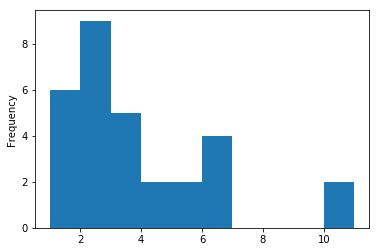

In [14]:
clasificacion_global['Real Madrid'].plot.hist()

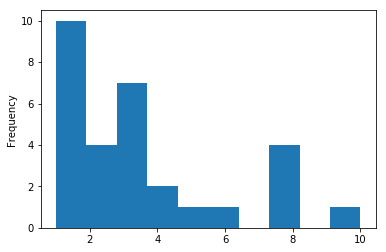

In [15]:
clasificacion_global['FC Barcelona'].plot.hist()

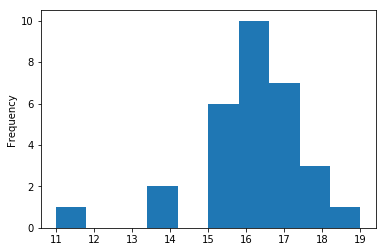

In [16]:
clasificacion_global['Granada CF'].plot.hist()

## Reflexiones

* ¿Qué información se te ocurre que puede ser interesante incorporar en esta simulación?
* ¿Puede el método de montecarlo ayudarnos a ganar una quiniela?